In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
from torch.optim import Adam,AdamW
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import functools
import time
from torchdiffeq import odeint_adjoint,odeint


from network_class import *
from utils import *


In [2]:

# a=torch.tensor(generate_2d(batch_size=10000,data_name="circles"))
# file_path = 'data/circles_2d.pt'
# torch.save(a, file_path)



In [3]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def grad_log_Gaussian(x):
    return -x

def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp

def stepRK1(odefun, z, net, t0, t1):
    h = t1 - t0 # step size
    K =  odefun(z, t0, net)
    return tuple( x+ h *y for x, y in zip(z, K))


def divergence_bf(dx, y):
    sum_diag = 0.
    for i in range(y.shape[1]):
        sum_diag += torch.autograd.grad(dx[:, i].sum(), y, create_graph=True)[0].contiguous()[:, i].contiguous()
    return sum_diag.contiguous()

def jac_div_graddivf(dx, y):
    jacobian=[]
    divergence= 0.
    for i in range(y.shape[1]):
        jacobian_i = torch.autograd.grad(dx[:,i].sum(), y, create_graph=True,retain_graph=True)[0].contiguous()
        divergence += jacobian_i[:, i].contiguous()
        jacobian.append(jacobian_i)
    stacked_jacobbian = torch.stack(jacobian, dim=2)
    grad_div_f=torch.autograd.grad(divergence.sum(), y, create_graph=True,retain_graph=True)[0]
    return stacked_jacobbian.contiguous(),divergence.contiguous().view(y.shape[0],1),grad_div_f

class ODE_forward(nn.Module):
    def __init__(self, net):
        super(ODE_forward, self).__init__()
        self.f_theta = net
    def forward(self, t, states):
        x = states[0]
        with torch.set_grad_enabled(True):
            x.requires_grad_(True)
            t.requires_grad_(True)

            dy = self.f_theta(t, x)
            divergence = divergence_bf(dy, x)

        divergence = divergence.contiguous().view(x.shape[0],1)

        return tuple([dy, -divergence])


def odefun(x, t, net):
    dx = net(t,x)
    return dx


def odefun_backward(cat_var, t, net):
    d=net.d
    x=cat_var[0]
    score=cat_var[2]
    


    divergence_f=torch.zeros(x.shape[0],device=device)
    
    f=net(t, x).reshape(x.shape[0],-1)

    jacobian = []
    for i in range(d):
        jacobian_i = autograd.grad(f[:,i].sum(), x, create_graph=True,retain_graph=True,)[0]
        jacobian.append(jacobian_i)
    stacked_jacobbian = torch.stack(jacobian, dim=2)


    divergence_f = torch.diagonal(stacked_jacobbian, dim1=-2, dim2=-1).sum(-1).reshape(-1,1)
    
    d_log=-divergence_f.reshape(-1,1)

    grad_div_f=autograd.grad(divergence_f.sum(), x, create_graph=True,retain_graph=True)[0]
    J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze()
    d_score=(-grad_div_f-J_mul_f)
    d_penalty=torch.mean(torch.sum((f+score)**2,dim=1))*torch.ones(x.shape[0],1).to(device)*0.5


    return (f,d_log,d_score,d_penalty)


In [4]:

device = 'cuda:2' #@param ['cuda', 'cpu'] {'type':'string'}

n_epochs =  800#@param {'type':'integer'}
batch_size =  1000 #@param {'type':'integer'}
lr=4e-2 #@param {'type':'number'}
tspan=[0,1]
data_name="checkerboard"  # "moon" "checkerboard" "circles"
d=2
nt=8
h=(tspan[1]-tspan[0])/nt


f_theta = ODEnet(d=2)
ODE_forward=ODE_forward(f_theta).to(device)
count_parameters(ODE_forward)
optim = AdamW(ODE_forward.parameters(), lr=lr,weight_decay=1e-5)





total parameter is:  9224


In [5]:

llh_record=[]
v_pen_record=[]
tqdm_epoch = tqdm.trange(n_epochs)

for epoch in tqdm_epoch:
    
    #resample
    if epoch%1==0:
        x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float()
        x = x.to(device)
         
    _logpz = torch.zeros(x.shape[0], 1).to(x)

    integration_times = torch.tensor([0.0, 1.]).float().to(device)
    state_t = odeint(
                ODE_forward,
                (x,_logpz),
                integration_times,
                atol=1e-5,
                rtol=1e-5,
                method="dopri5"
            )
    z_terminal,delta_log=tuple(s[1] for s in state_t)  #delta_log = \int -trace
    log_terminal=log_Gaussian(x=z_terminal,d=d)
    likelihood=torch.mean(log_terminal)-delta_log.mean()

    score_terminal=grad_log_Gaussian(z_terminal)
    

    tk=tspan[1]
    tk=torch.tensor([tk]).squeeze().to(x)
    z_back=z_terminal

    bridge_penalty=torch.zeros(x.shape[0], 1).to(x)
    cat_var=(z_back,log_terminal,score_terminal,torch.zeros(x.shape[0], 1).to(x))

    
    for k in  range(nt):
        cat_var= stepRK1(odefun_backward, cat_var , f_theta, tk, tk-h)
        tk-=h

    z,log_inv,score,bridge_pen=cat_var
    bridge_pen=-bridge_pen.mean()
    print(bridge_pen)
    loss=-likelihood*10  + bridge_pen

    
    optim.zero_grad()
    loss.backward()
    optim.step()
    llh_record.append(-likelihood.detach().cpu())
    v_pen_record.append(-bridge_pen.detach().cpu())
    tqdm_epoch.set_description('nll: {:5f} Bridge: {:5f}  '.format(-likelihood.detach().cpu(),-bridge_pen.detach().cpu()))

    if (epoch+1) % 50== 0:  ##Viz
        torch.save(f_theta.state_dict(), f'experiment/{data_name}/{data_name}_2d.pth')

        #forward process
        x=torch.tensor(generate_2d(batch_size=10000,data_name=data_name)).float().to(device)
        integration_times = torch.linspace(0,1,8).to(device)
        state_t_forward = odeint(f_theta,x,integration_times,atol=1e-5,rtol=1e-5,method="dopri5")

        x=torch.randn(10000,2).to(device)
        integration_times = torch.linspace(1,0,8).to(device)
        state_t_backward = odeint(f_theta,x,integration_times,atol=1e-5,rtol=1e-5,method="dopri5")

        plot_z_state(state_t_forward,state_t_backward,save_path='experiment/'+data_name+'/pic/Forward_backward.png')

        x=torch.randn(10000,2).to(device)
        integration_times = torch.linspace(1,0,21).to(device)
        state_t = odeint(f_theta,x,integration_times,atol=1e-5,rtol=1e-5,method="dopri5")
        plot_ode_trajectory(state_t,save_path='experiment/'+data_name+'/pic/trajectories.png')
        






  0%|          | 0/800 [00:00<?, ?it/s]

tensor(5.2970, device='cuda:2', grad_fn=<NegBackward>)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 1]] is at version 9; expected version 8 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

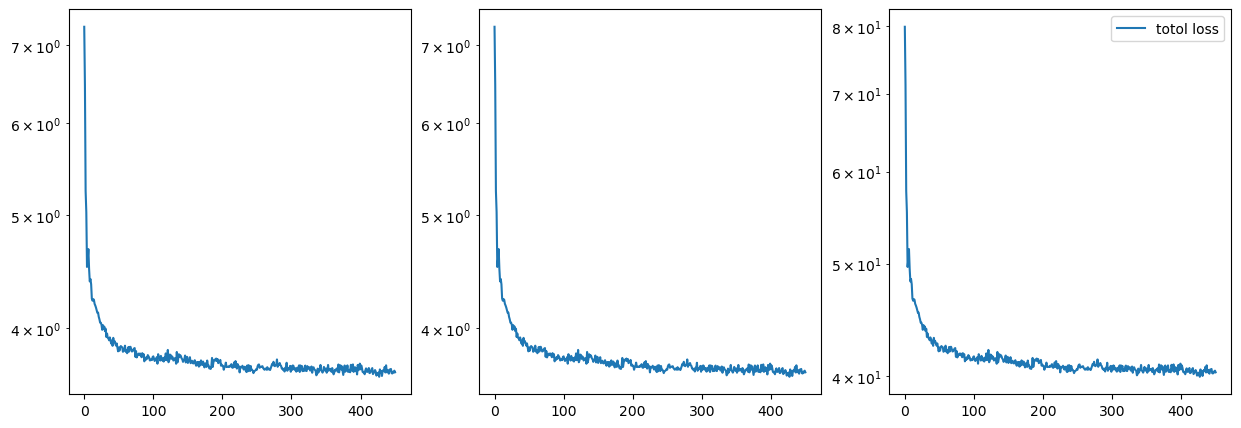

IndexError: list index out of range

In [ ]:

# plot_loss(llh_record)
plot_loss_all(llh_record,v_pen_record)
print(v_pen_record[-1])
